# Image_Proccess_Filter

## 1. Preprocess

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display
import skimage
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'Image_Proccess_Filter'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_Image_Proccess_20180106_080454


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/input
log_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/log
model_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/model
output_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/output


### Basic functions

In [37]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [50]:
def show_data_images(rows, fig_column, id_data, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title(id_data[i] + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [45]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)
print(pd_data.columns)
print(pd_test.columns)

(1604, 5)
(8424, 4)
Index(['band_1', 'band_2', 'id', 'inc_angle', 'is_iceberg'], dtype='object')
Index(['band_1', 'band_2', 'id', 'inc_angle'], dtype='object')
CPU times: user 9.08 s, sys: 2.42 s, total: 11.5 s
Wall time: 11.5 s


In [40]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
describe(id_data)
describe(id_test)

id_data_path = os.path.join(input_path, 'id_data.p')
id_test_path = os.path.join(input_path, 'id_test.p')
pickle.dump(id_data, open(id_data_path, 'wb'))
pickle.dump(id_test, open(id_test_path, 'wb'))

(1604,) 000d71b1 fffe76e4 96
(8424,) 000c65d7 fff77564 96


In [48]:
is_iceberg = pd_data['is_iceberg']
describe(is_iceberg)

y_data = is_iceberg

is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
pickle.dump(is_iceberg, open(is_iceberg_path, 'wb'))

(1604,) 0 1 25688


In [47]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)

describe(inc_angle_data)
describe(inc_angle_test)

inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

pickle.dump(inc_angle_data, open(inc_angle_data_path, 'wb'))
pickle.dump(inc_angle_test, open(inc_angle_test_path, 'wb'))

(1604,) 0.0 45.9375 25688
(8424,) 23.0805 50.66178518 134808


In [11]:
#get numpy arrays for train/test data, prob there is a more pythonic approach
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])

im_avg = (im1 + im2)/2.0
    
#get numpy array for test data
band1test = pd_test['band_1'].values
im1test = np.zeros((len(band1test),len(band1test[0])))
for j in range(len(band1test)):
    im1test[j,:]=np.asarray(band1test[j])
    
band2test = pd_test['band_2'].values
im2test = np.zeros((len(band2test),len(band2test[0])))
for j in range(len(band2test)):
    im2test[j,:]=np.asarray(band2test[j])

In [49]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1test.reshape(-1, 75,75)
band2_test = im2test.reshape(-1, 75,75)

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

band1_data_path = os.path.join(input_path, 'band1_data.p')
band2_data_path = os.path.join(input_path, 'band2_data.p')
band1_test_path = os.path.join(input_path, 'band1_test.p')
band2_test_path = os.path.join(input_path, 'band2_test.p')

pickle.dump(band1_data, open(band1_data_path, 'wb'))
pickle.dump(band2_data, open(band2_data_path, 'wb'))
pickle.dump(band1_test, open(band1_test_path, 'wb'))
pickle.dump(band2_test, open(band2_test_path, 'wb'))

x_data = pickle.load(open(band1_data_path, mode='rb'))

(1604, 75, 75) -45.594448 34.574917 128
(1604, 75, 75) -45.655499 20.154249 128
(8424, 75, 75) -45.6805458069 37.090523 128
(8424, 75, 75) -49.0835 37.0905227661 128


In [17]:
band_avg_data = (band1_data + band2_data)/2
describe(band_avg_data)
band_avg_test = (band1_test + band2_test)/2
describe(band_avg_test)

band_avg_data_path = os.path.join(input_path, 'band_avg_data.p')
band_avg_test_path = os.path.join(input_path, 'band_avg_test.p')

pickle.dump(band_avg_data, open(band_avg_data_path, 'wb'))
pickle.dump(band_avg_test, open(band_avg_test_path, 'wb'))

(1604, 75, 75)
(8424, 75, 75)


In [51]:
describe(band1_data)

(1604, 75, 75) -45.594448 34.574917 128


(75, 75)


Text(0.5,1,'5941774d')

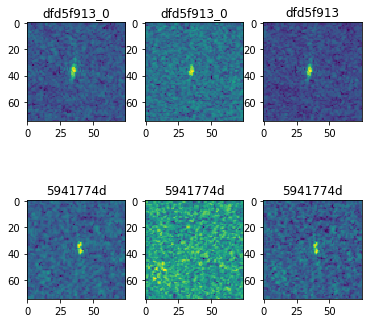

In [18]:
# Preview images
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[0].reshape(75, 75))
ax[0, 0].set_title(id_data[0] + '_' + str(y_data[0]))
ax[0, 1].imshow(band2_data[0].reshape(75, 75))
ax[0, 1].set_title(id_data[0] + '_' + str(y_data[1]))
ax[0, 2].imshow(band_avg_data[0].reshape(75, 75))
ax[0, 2].set_title(id_data[0])

ax[1, 0].imshow(band1_test[0].reshape(75, 75))
ax[1, 0].set_title(id_test[0])
ax[1, 1].imshow(band2_test[0].reshape(75, 75))
ax[1, 1].set_title(id_test[0])
ax[1, 2].imshow(band_avg_test[0].reshape(75, 75))
ax[1, 2].set_title(id_test[0])

### Binarizer

二值化的效果不够理想

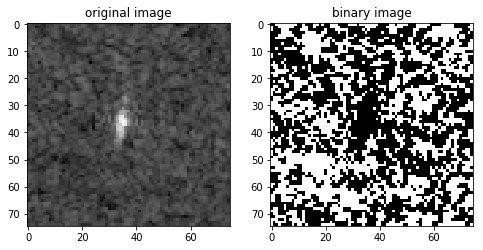

In [19]:
from skimage import data,filters
import matplotlib.pyplot as plt
index = 0
image = band1_data[index]
# image = band1_data_edges[index]
thresh = filters.threshold_otsu(image)   #返回一个阈值
dst =(image <= thresh)*1.0   #根据阈值进行分割

plt.figure('thresh',figsize=(8,8))

plt.subplot(121)
plt.title('original image')
plt.imshow(image,plt.cm.gray)

plt.subplot(122)
plt.title('binary image')
plt.imshow(dst,plt.cm.gray)

plt.show()

(75, 75)
Binarizer(copy=True, threshold=-22.44550520353285)
Binarizer(copy=True, threshold=-24.693380698518308)
Binarizer(copy=True, threshold=-23.488266381686106)


Text(0.5,1,'e7f018bb')

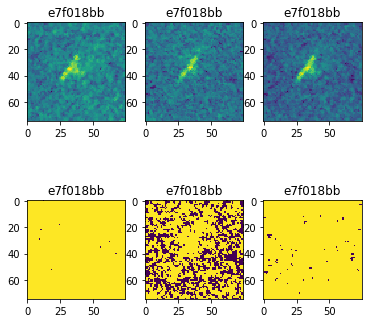

In [20]:
# Preview images
index = 3
print(band1_test[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_test[index].reshape(75, 75))
ax[0, 0].set_title(id_test[index])
ax[0, 1].imshow(band2_test[index].reshape(75, 75))
ax[0, 1].set_title(id_test[index])
ax[0, 2].imshow(band_avg_test[index].reshape(75, 75))
ax[0, 2].set_title(id_test[index])

binarizer1 = Binarizer(copy=True, threshold=im1test.mean()).fit(im1test)
print(binarizer1)
band1_test_bin = binarizer1.transform(im1test)

binarizer2 = Binarizer(copy=True, threshold=im2test.mean()).fit(im2test)
print(binarizer2)
band2_test_bin = binarizer2.transform(im2test)

im_test_avg = (im1test + im2test)/2
binarizer_avg = Binarizer(copy=True, threshold=im_avg.mean()).fit(im_test_avg)
print(binarizer_avg)
band_test_avg_bin = binarizer_avg.transform(im_test_avg)

ax[1, 0].imshow(band1_test_bin[index].reshape(75, 75))
ax[1, 0].set_title(id_test[index])
ax[1, 1].imshow(band2_test_bin[index].reshape(75, 75))
ax[1, 1].set_title(id_test[index])
ax[1, 2].imshow(band_test_avg_bin[index].reshape(75, 75))
ax[1, 2].set_title(id_test[index])

### Color hist
**References:**
- http://www.cnblogs.com/denny402/p/5124833.html

(75, 75)


Text(0.5,1,'dfd5f913')

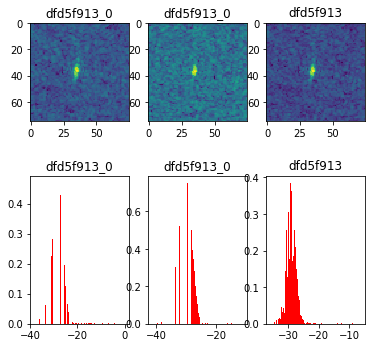

In [21]:
# Preview images
index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index].reshape(75, 75))
ax[0, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 1].imshow(band2_data[index].reshape(75, 75))
ax[0, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 2].imshow(band_avg_data[index].reshape(75, 75))
ax[0, 2].set_title(id_data[index])

ax[1, 0].hist(band1_data[index].reshape(75*75), bins=256, normed=1,edgecolor='None',facecolor='red')
ax[1, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 1].hist(band2_data[index].reshape(75*75), bins=256, normed=1,edgecolor='None',facecolor='red')
ax[1, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 2].hist(band_avg_data[index].reshape(75*75), bins=256, normed=1,edgecolor='None',facecolor='red')
ax[1, 2].set_title(id_data[index])

### Filter
** Refernces:**
- http://www.cnblogs.com/denny402/p/5125253.html

sobel算子可用来检测边缘

函数格式为：skimage.filters.sobel(image, mask=None)

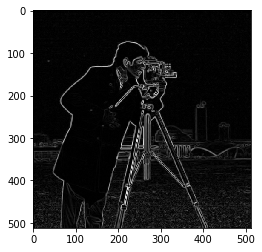

In [22]:
from skimage import data,filters
import matplotlib.pyplot as plt
img = data.camera()
edges = filters.sobel(img)
plt.imshow(edges,plt.cm.gray)

(75, 75)
0.0
13.8904304436


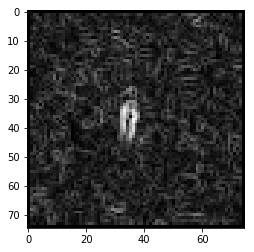

In [23]:
from skimage import data,filters
import matplotlib.pyplot as plt
# img = data.camera()
edges = filters.sobel(band1_data[index])
print(edges.shape)
print(edges.min())
print(edges.max())
plt.imshow(edges,plt.cm.gray)

(75, 75)
1604
(1604, 75, 75)


Text(0.5,1,'dfd5f913')

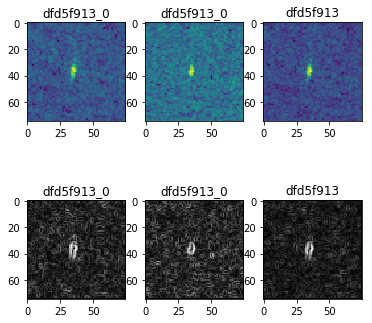

In [24]:
# Preview images
from skimage import data,filters
import matplotlib.pyplot as plt

index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index])
ax[0, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 1].imshow(band2_data[index])
ax[0, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 2].imshow(band_avg_data[index])
ax[0, 2].set_title(id_data[index])

band1_data_edges = [filters.sobel(x) for x in band1_data]
print(len(band1_data_edges))
band1_data_edges = np.array(band1_data_edges)
print(band1_data_edges.shape)

band2_data_edges = np.array([filters.sobel(x) for x in band2_data])
band_avg_data_edges = np.array([filters.sobel(x) for x in band_avg_data])

ax[1, 0].imshow(band1_data_edges[index], plt.cm.gray)
ax[1, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 1].imshow(band2_data_edges[index], plt.cm.gray)
ax[1, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 2].imshow(band_avg_data_edges[index], plt.cm.gray)
ax[1, 2].set_title(id_data[index])

(75, 75)
8424
(8424, 75, 75)


Text(0.5,1,'5941774d')

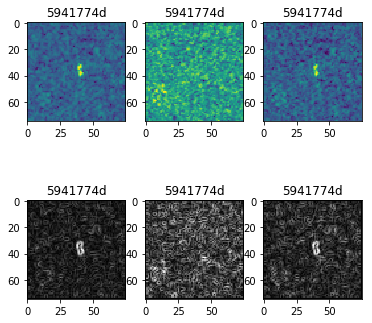

In [25]:
index = 0
print(band1_test[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_test[index])
ax[0, 0].set_title(id_test[index])
ax[0, 1].imshow(band2_test[index])
ax[0, 1].set_title(id_test[index])
ax[0, 2].imshow(band_avg_test[index])
ax[0, 2].set_title(id_test[index])

band1_test_edges = [filters.sobel(x) for x in band1_test]
print(len(band1_test_edges))
band1_test_edges = np.array(band1_test_edges)
print(band1_test_edges.shape)

band2_test_edges = np.array([filters.sobel(x) for x in band2_test])
band_avg_test_edges = np.array([filters.sobel(x) for x in band_avg_test])

ax[1, 0].imshow(band1_test_edges[index], plt.cm.gray)
ax[1, 0].set_title(id_test[index])
ax[1, 1].imshow(band2_test_edges[index], plt.cm.gray)
ax[1, 1].set_title(id_test[index])
ax[1, 2].imshow(band_avg_test_edges[index], plt.cm.gray)
ax[1, 2].set_title(id_test[index])

In [26]:
print(band1_data_edges.shape)
print(band2_data_edges.shape)
print(band_avg_data_edges.shape)
print(band1_test_edges.shape)
print(band2_test_edges.shape)
print(band_avg_test_edges.shape)

band1_data_edges_path = os.path.join(input_path, 'band1_data_edges.p')
band2_data_edges_path = os.path.join(input_path, 'band2_data_edges.p')
band_avg_data_edges_path = os.path.join(input_path, 'band_avg_data_edges.p')
band1_test_edges_path = os.path.join(input_path, 'band1_test_edges.p')
band2_test_edges_path = os.path.join(input_path, 'band2_test_edges.p')
band_avg_test_edges_path = os.path.join(input_path, 'band_avg_test_edges.p')

pickle.dump(band1_data_edges, open(band1_data_edges_path, 'wb'))
pickle.dump(band2_data_edges, open(band2_data_edges_path, 'wb'))
pickle.dump(band_avg_data_edges, open(band_avg_data_edges_path, 'wb'))
pickle.dump(band1_test_edges, open(band1_test_edges_path, 'wb'))
pickle.dump(band2_test_edges, open(band2_test_edges_path, 'wb'))
pickle.dump(band_avg_test_edges, open(band_avg_test_edges_path, 'wb'))

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


gabor滤波
gabor滤波可用来进行边缘检测和纹理特征提取

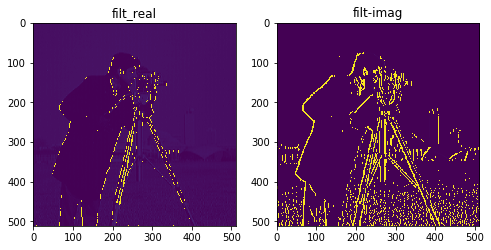

In [27]:
from skimage import data,filters
import matplotlib.pyplot as plt
img = data.camera()
filt_real, filt_imag = filters.gabor(img,frequency=0.6)   

plt.figure('gabor',figsize=(8,8))

plt.subplot(121)
plt.title('filt_real')
# plt.imshow(filt_real,plt.cm.gray)
plt.imshow(filt_real)

plt.subplot(122)
plt.title('filt-imag')
plt.imshow(filt_imag)

plt.show()

(75, 75)
1604
(1604, 75, 75)
CPU times: user 4min 31s, sys: 0 ns, total: 4min 31s
Wall time: 4min 31s


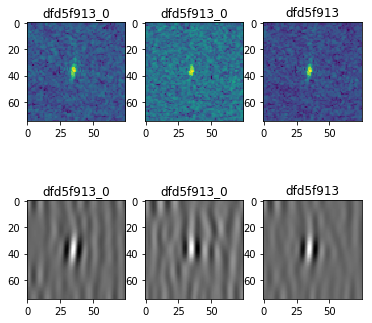

In [28]:
%%time

from skimage import data,filters
import matplotlib.pyplot as plt

index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index])
ax[0, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 1].imshow(band2_data[index])
ax[0, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 2].imshow(band_avg_data[index])
ax[0, 2].set_title(id_data[index])

band1_data_gabor = [filters.gabor(x, frequency=0.1)[0] for x in band1_data]
print(len(band1_data_gabor))
band1_data_gabor = np.array(band1_data_gabor)
print(band1_data_gabor.shape)

band2_data_gabor = np.array([filters.gabor(x, frequency=0.1)[0] for x in band2_data])
band_avg_data_gabor = np.array([filters.gabor(x, frequency=0.1)[0] for x in band_avg_data])

ax[1, 0].imshow(band1_data_gabor[index], plt.cm.gray)
ax[1, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 1].imshow(band2_data_gabor[index], plt.cm.gray)
ax[1, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 2].imshow(band_avg_data_gabor[index], plt.cm.gray)
ax[1, 2].set_title(id_data[index])

(75, 75)
8424
(8424, 75, 75)


KeyboardInterrupt: 

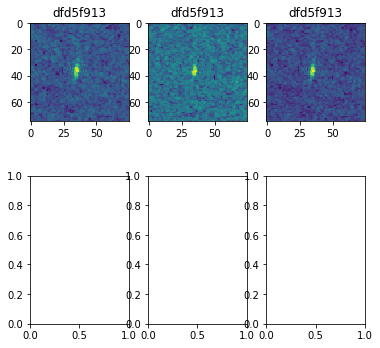

In [29]:
%%time

from skimage import data,filters
import matplotlib.pyplot as plt

index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index])
ax[0, 0].set_title(id_data[index])
ax[0, 1].imshow(band2_data[index])
ax[0, 1].set_title(id_data[index])
ax[0, 2].imshow(band_avg_data[index])
ax[0, 2].set_title(id_data[index])

band1_test_gabor = [filters.gabor(x, frequency=0.1)[0] for x in band1_test]
print(len(band1_test_gabor))
band1_test_gabor = np.array(band1_test_gabor)
print(band1_test_gabor.shape)

band2_test_gabor = np.array([filters.gabor(x, frequency=0.1)[0] for x in band2_test])
band_avg_test_gabor = np.array([filters.gabor(x, frequency=0.1)[0] for x in band_avg_test])

# ax[1, 0].imshow(band1_test_gabor[index], plt.cm.gray)
ax[1, 0].imshow(band1_test_gabor[index])
ax[1, 0].set_title(id_data[index])
ax[1, 1].imshow(band2_test_gabor[index], plt.cm.gray)
ax[1, 1].set_title(id_data[index])
ax[1, 2].imshow(band_avg_test_gabor[index])
ax[1, 2].set_title(id_data[index])

In [30]:
%%time
print(band1_data_gabor.shape)
print(band2_data_gabor.shape)
print(band_avg_data_gabor.shape)
print(band1_test_gabor.shape)
print(band2_test_gabor.shape)
print(band_avg_test_gabor.shape)

band1_data_gabor_path = os.path.join(input_path, 'band1_data_gabor.p')
band2_data_gabor_path = os.path.join(input_path, 'band2_data_gabor.p')
band_avg_data_gabor_path = os.path.join(input_path, 'band_avg_data_gabor.p')
band1_test_gabor_path = os.path.join(input_path, 'band1_test_gabor.p')
band2_test_gabor_path = os.path.join(input_path, 'band2_test_gabor.p')
band_avg_test_gabor_path = os.path.join(input_path, 'band_avg_test_gabor.p')

pickle.dump(band1_data_gabor, open(band1_data_gabor_path, 'wb'))
pickle.dump(band2_data_gabor, open(band2_data_gabor_path, 'wb'))
pickle.dump(band_avg_data_gabor, open(band_avg_data_gabor_path, 'wb'))
pickle.dump(band1_test_gabor, open(band1_test_gabor_path, 'wb'))
pickle.dump(band2_test_gabor, open(band2_test_gabor_path, 'wb'))
pickle.dump(band_avg_test_gabor, open(band_avg_test_gabor_path, 'wb'))

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


NameError: name 'band_avg_test_gabor' is not defined

### SIFT

In [31]:
# #coding=utf-8 
# import cv2 
# import scipy as sp 
  
# img1 = cv2.imread('.\\input\\cat.3.jpg',0) # queryImage 
# img2 = cv2.imread('.\\input\\cat.7.jpg',0) # trainImage 
# cv2.imshow("view", img1)

In [32]:
# Initiate SIFT detector 
# sift = cv2.SIFT()

In [33]:

  
# # find the keypoints and descriptors with SIFT 
# kp1, des1 = sift.detectAndCompute(img1,None) 
# kp2, des2 = sift.detectAndCompute(img2,None) 
  
# # FLANN parameters 
# FLANN_INDEX_KDTREE = 0
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5) 
# search_params = dict(checks=50)  # or pass empty dictionary 
# flann = cv2.FlannBasedMatcher(index_params,search_params) 
# matches = flann.knnMatch(des1,des2,k=2) 
  
# print 'matches...',len(matches) 
# # Apply ratio test 
# good = [] 
# for m,n in matches: 
#     if m.distance < 0.75*n.distance: 
#         good.append(m) 
# print 'good',len(good) 
# # ##################################### 
# # visualization 
# h1, w1 = img1.shape[:2] 
# h2, w2 = img2.shape[:2] 
# view = sp.zeros((max(h1, h2), w1 + w2, 3), sp.uint8) 
# view[:h1, :w1, 0] = img1 
# view[:h2, w1:, 0] = img2 
# view[:, :, 1] = view[:, :, 0] 
# view[:, :, 2] = view[:, :, 0] 
  
# for m in good: 
#   # draw the keypoints 
#   # print m.queryIdx, m.trainIdx, m.distance 
#   color = tuple([sp.random.randint(0, 255) for _ in xrange(3)]) 
#   #print 'kp1,kp2',kp1,kp2 
#   cv2.line(view, (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])) , (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1])), color) 
  
# cv2.imshow("view", view) 
# cv2.waitKey() 

In [34]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 1524.27 s
Done!


In [35]:
print(run_name)

SC_Iceberg_Classifier_Image_Proccess_20180106_080454
